In [9]:
#######################Prophet model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
import pymysql
from datetime import datetime, timedelta
from fbprophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

dbCon = pymysql.connect('host', 'username', 'password', 'database',
                       charset ='utf8', autocommit=True,
                       cursorclass=pymysql.cursors.DictCursor)

#x1: Variable cost / 변동비
x1='''SELECT  cc_costbill1.version_id AS ds, cc_costbill1.ic_dlvc+ cc_costbill1.ic_ohdvc AS y
FROM cc_costbill1, cc_itemplan
WHERE itemplan_id=1 AND cc_costbill1.itemplan_id=cc_itemplan.id'''#직접, 노무비,

#x2: Fized cost / 고정비
x2='''SELECT cc_costbill1.ic_dlfc+cc_costbill1.ic_idlc
+cc_costbill1.ic_ohdfd+cc_costbill1.ic_ohdfe +cc_costbill1.ic_idohc AS x1,
cc_costbill1.version_id as date
FROM cc_costbill1, cc_itemplan
WHERE itemplan_id=1 AND cc_costbill1.itemplan_id=cc_itemplan.id''' #가만히있어도 돈dl 나가는 고정비

#y: Cost / 생산액
y='''SELECT cc_costbill1.proamt_unit*cc_costbill1.proq AS y, cc_costbill1.version_id AS ds
FROM cc_costbill1, cc_itemplan
WHERE itemplan_id=1 AND cc_costbill1.itemplan_id=cc_itemplan.id'''

curs = dbCon.cursor()
curs.execute(y)
result =curs.fetchall()

df = pd.DataFrame(result)
df1=pd.DataFrame(result)
#int -> datetime
df['ds'] = df['ds'].astype(str)
df['ds'] = pd.to_datetime(df['ds'])

#covid19 trend (special events)
covid = pd.DataFrame({
'holiday': 'playoff',
'ds': pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01',
                     '2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
                     '2020-09-01','2020-10-01','2020-11-01','2020-12-01',]),
'lower_window': -1,
'upper_window': 0,
})
#inflation
inflation = pd.DataFrame({
'holiday': 'playoff',
'ds': pd.to_datetime(['2009-01-01', '2009-02-01','2009-03-01',
                     '2009-04-01','2009-05-01','2009-06-01','2009-07-01','2009-08-01',
                     '2009-09-01','2009-10-01','2009-11-01','2009-12-01',]),
'lower_window': -1,
'upper_window': 0,
})

holidays = pd. concat((covid, inflation))

#Build model / 모델 만들기
model= Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=False,
    yearly_seasonality=20,
    daily_seasonality=False,
# Uncertainty Intervals: 95%
    interval_width = 0.95,
    holidays=holidays
)

C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


            ds          yhat    yhat_lower    yhat_upper
0   2000-01-01  2.583262e+08 -5.789532e+08  1.085960e+09
1   2000-02-01  2.284247e+08 -6.135671e+08  1.058585e+09
2   2000-03-01  1.201608e+08 -7.911399e+08  1.037184e+09
3   2000-04-01  1.024611e+08 -6.439759e+08  8.323215e+08
4   2000-05-01  1.248878e+07 -8.667444e+08  8.286028e+08
..         ...           ...           ...           ...
247 2020-08-01  4.475015e+09  3.662715e+09  5.264682e+09
248 2020-09-01  4.383670e+09  3.565902e+09  5.152208e+09
249 2020-10-01  4.467969e+09  3.645669e+09  5.299044e+09
250 2020-11-01  4.388615e+09  3.574428e+09  5.116997e+09
251 2020-12-01  4.477816e+09  3.646523e+09  5.297671e+09

[252 rows x 4 columns]


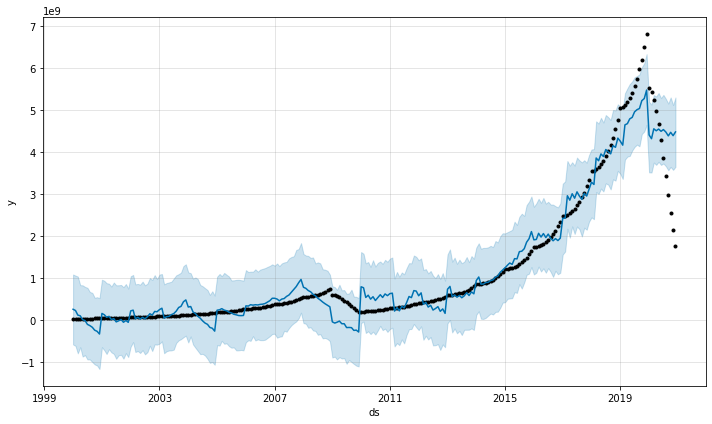

In [10]:
#Add monthly pattern because data is month based data / 월주기 패턴 추가
model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
model.fit(df)
forecast = model.predict(df)

# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
model.plot(forecast)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


            ds          yhat    yhat_lower    yhat_upper
0   2000-01-01  2.583262e+08 -5.742132e+08  1.118216e+09
1   2000-02-01  2.284247e+08 -6.141571e+08  1.010835e+09
2   2000-03-01  1.201608e+08 -6.896479e+08  9.370097e+08
3   2000-04-01  1.024611e+08 -7.278425e+08  9.445264e+08
4   2000-05-01  1.248878e+07 -7.753221e+08  8.648546e+08
..         ...           ...           ...           ...
259 2021-08-01  6.163326e+09  5.353695e+09  7.030660e+09
260 2021-09-01  6.198651e+09  5.402535e+09  7.029796e+09
261 2021-10-01  6.230555e+09  5.403041e+09  7.101009e+09
262 2021-11-01  6.276938e+09  5.438279e+09  7.140731e+09
263 2021-12-01  6.329730e+09  5.473438e+09  7.148251e+09

[264 rows x 4 columns]


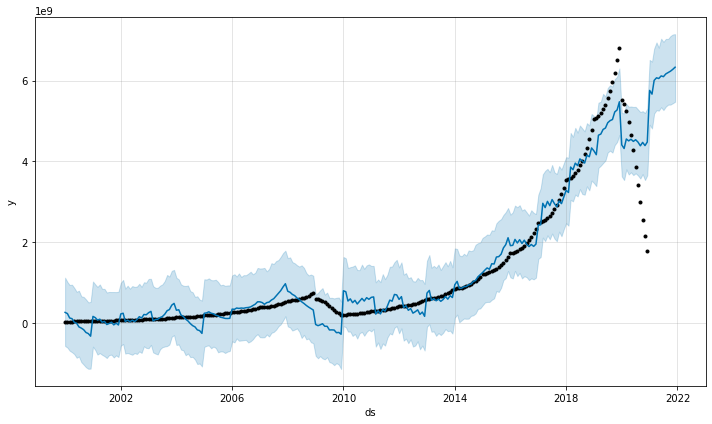

In [11]:
#With trained data(2000-01~2020-12)-> predict 2021-01~2021-12 
future = list()
for i in range(1, 13):
	date = '2021-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
# print(future)
future['ds']= pd.to_datetime(future['ds'])
forecast1= pd.concat((forecast, future))

# use the model to make a forecast
forecast1 = model.predict(forecast1)
# summarize the forecast
print(forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
model.plot(forecast1)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


MAE: 1318835691.014
MSE: 2700300364162089472.000
RMSE: 1643259067.878
RMSLE: 0.445
              y         ds
0      31748050 2000-01-01
1      31880576 2000-02-01
2      32193315 2000-03-01
3      32594496 2000-04-01
4      33255268 2000-05-01
..          ...        ...
187  1376959962 2015-08-01
188  1432533760 2015-09-01
189  1486756904 2015-10-01
190  1562087072 2015-11-01
191  1634567428 2015-12-01

[192 rows x 2 columns]


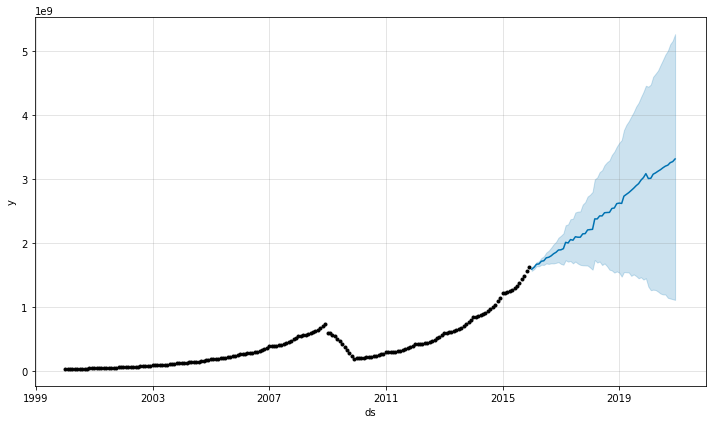

In [8]:
import numpy as np
#Train: 2000~2017,  Test: 2018~2020
train = df.drop(df.index[-60:])
y_true = df['y'][-60:].values

#covid19 트렌드 설정 (special events)
covid = pd.DataFrame({
'holiday': 'playoff',
'ds': pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01',
                     '2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
                     '2020-09-01','2020-10-01','2020-11-01','2020-12-01',]),
'lower_window': -1,
'upper_window': 0,
})
#Economy inflation
inflation = pd.DataFrame({
'holiday': 'playoff',
'ds': pd.to_datetime(['2009-01-01', '2009-02-01','2009-03-01',
                     '2009-04-01','2009-05-01','2009-06-01','2009-07-01','2009-08-01',
                     '2009-09-01','2009-10-01','2009-11-01','2009-12-01',]),
'lower_window': -1,
'upper_window': 0,
})
holidays = pd. concat((covid, inflation))
#월주기 패턴 추가
# 모델 생성 후 학습
model1 = Prophet(# trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=False,
    yearly_seasonality=20,
    daily_seasonality=False,
    interval_width = 0.95,
    holidays=holidays)

model1.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)

model1.fit(train)

# train set 마지막 1년 날짜 생성
last_1year = list()
for i in range(1, 13):
    last_1year.append(['2016-%02d' % i])
for i in range(1, 13):
    last_1year.append(['2017-%02d' % i])
for i in range(1, 13):
    last_1year.append(['2018-%02d' % i])
for i in range(1, 13):
    last_1year.append(['2019-%02d' % i])
for i in range(1, 13):
    last_1year.append(['2020-%02d' % i])        
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.
forecast = model1.predict(last_1year)
y_pred = forecast['yhat'].values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
mae = mean_absolute_error(y_true, y_pred)
MSE = mean_squared_error(y_true, y_pred)
RMSE = np.sqrt(MSE)
RMSLE = np.sqrt(mean_squared_log_error(y_true, y_pred))

print('MAE: %.3f' % mae)
print('MSE: %.3f' % MSE)
print('RMSE: %.3f' % RMSE)
print('RMSLE: %.3f' % RMSLE)


print(train)
model1.plot(forecast)
plt.show()

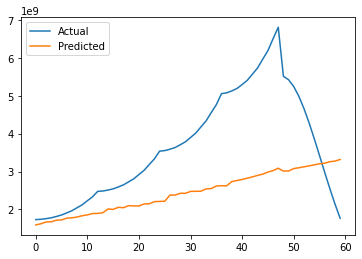

In [9]:
#3년 예측치 결과
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')

plt.legend()
plt.show()

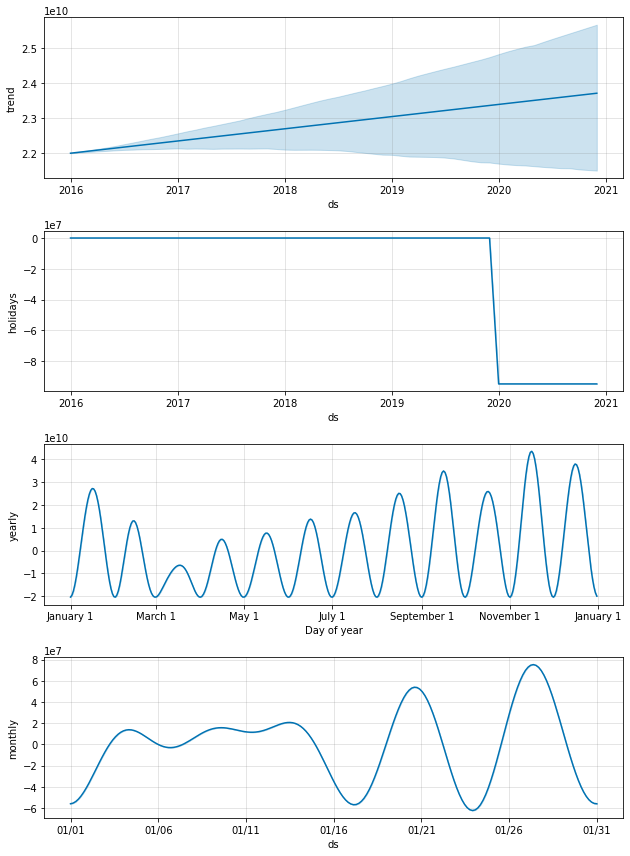

In [10]:
fig2 = model1.plot_components(forecast)
